# Basic CLN Construction and Training

In [95]:
import cln

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import trange
import pandas as pd

def scale(arr, max=1.0):
    arr = np.array(arr)
    return arr * max/arr.max()

### CLN construction
Illustrate with formula from slides:

$(x = 1) \lor ((x > 3) \land (x < 4)) \lor (x > 5)$

No handles with labels found to put in legend.


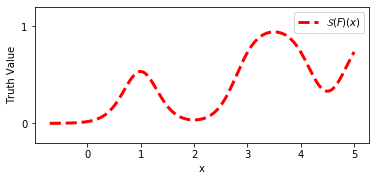

In [7]:
# Can construct CLN using either functional primitives or pytorch modules

# example with basic functions
from cln import prod_tnorm, prod_tconorm, eq, le, ge


B = 5
eps = 0.2

x = torch.tensor(np.linspace(-0.7, 5, 1001))
ycln = prod_tconorm([eq(x - 1.0, B, eps),
                     prod_tnorm([ge(x - 3, B, eps), 
                                 le(x - 4, B, eps)]), 
                    ge(x - 5, B, eps)])


figsize = (6,2.5)
linewidth = 3
plt.figure(figsize=figsize) # SETTING

# plt.plot(x, ydiscrete, 'steelblue', linewidth=2)
plt.plot(x, ycln, 'r--', linewidth=3)
 
plt.legend()
plt.xlabel('x')
plt.ylabel('Truth Value')
plt.ylim([-0.2, 1.2])
plt.yticks([0,1])

plt.legend(['$\mathcal{S}(F)(x)$'])

No handles with labels found to put in legend.


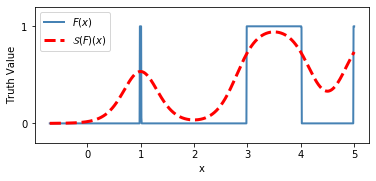

In [10]:
Bdisc = 4000
eps_disc=0.015

ydiscrete = prod_tconorm([eq(x - 1.0, B=Bdisc, eps=eps_disc),
                      prod_tnorm([ge(x - 3, Bdisc, eps_disc), 
                                 le(x - 4, Bdisc, eps_disc)]), 
                         ge(x - 5, Bdisc, eps_disc)])

figsize = (6,2.5)
linewidth = 3
plt.figure(figsize=figsize) # SETTING

plt.plot(x, ydiscrete, 'steelblue', linewidth=2)
plt.plot(x, ycln, 'r--', linewidth=3)
 
plt.legend()
plt.xlabel('x')
plt.ylabel('Truth Value')
plt.ylim([-0.2, 1.2])
plt.yticks([0,1])

plt.legend(['$F(x)$', '$\mathcal{S}(F)(x)$'])

### Solving with Functional API:

In [58]:
# define model using cln functional API:

class CLNModel(torch.nn.Module):
    def __init__(self, B):
        super(CLNModel, self).__init__()
        self.B = B
        self.eps = 0.5
        
    def forward(self, x):
        B = self.B
        eps = self.eps
        
        ycln = prod_tconorm([eq(x - 1, B, eps),
                     prod_tnorm([ge(x - 3, B, eps), 
                                 le(x - 4, B, eps)]), 
                    ge(x - 5, B, eps)])
        return ycln
    
    
x = torch.tensor(2.0, requires_grad=True)

model = CLNModel(B=5.0)

out = model(x)
print(x, out)

tensor(2., requires_grad=True) tensor(0.1459, grad_fn=<SubBackward0>)


Lowering B increases smoothing:

In [60]:
# try lowering B:
model = CLNModel(B=2.0)

out = model(x)
print(x, out)

tensor(2., requires_grad=True) tensor(0.4585, grad_fn=<SubBackward0>)


In [64]:
model = CLNModel(B=0.5)

out = model(x)
print(x, out)

tensor(2., requires_grad=True) tensor(0.6397, grad_fn=<SubBackward0>)


Now find solution using model:

In [78]:
def train(x, model):
    opt = torch.optim.Adam(params=[x] + list(model.parameters()), lr=0.1)
    
    x_trace = []
    loss_trace = []
    for i in trange(100):
        opt.zero_grad()
        
        cln_out = model(x)
        loss = 1 - cln_out
        
        loss_trace.append(loss.item())
        x_trace.append(x.item())

        loss.backward()
        opt.step()
                
    return pd.DataFrame({'loss':loss_trace, 'x':x_trace})
    
    

x = torch.tensor(2.0, requires_grad=True)
model = CLNModel(B=3.0)

print('x before', x, '\nloss before', 1-model(x))
trace = train(x, model)
print('\nx after', x, '\nloss after', 1-model(x))





100%|██████████| 100/100 [00:00<00:00, 1111.73it/s]

x before tensor(2., requires_grad=True) 
loss before tensor(0.6698, grad_fn=<RsubBackward1>)

x after tensor(3.5235, requires_grad=True) 
loss after tensor(0.0879, grad_fn=<RsubBackward1>)


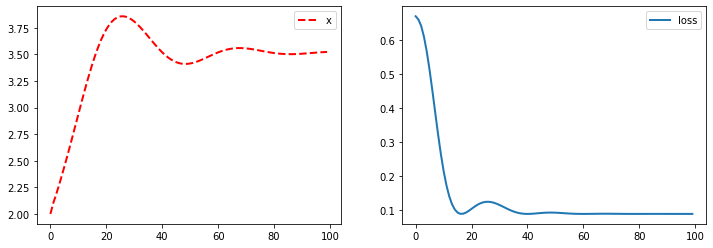

In [80]:
# can plot to see what's going on
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(trace.x, 'r--', linewidth=2)
plt.legend(['x', 'B'])
plt.subplot(1,2,2)
plt.plot(trace.loss, linewidth=2)
plt.legend(['loss'])

Works well with this B value, but what if we lower it to increase smoothing?

In [81]:
x = torch.tensor(2.0, requires_grad=True)
model = CLNModel(B=0.5)

print('x before', x, '\nloss before', 1-model(x))
trace = train(x, model)
print('\nx after', x, '\nloss after', 1-model(x))

100%|██████████| 100/100 [00:00<00:00, 1165.27it/s]

x before tensor(2., requires_grad=True) 
loss before tensor(0.3603, grad_fn=<RsubBackward1>)

x after tensor(11.2084, requires_grad=True) 
loss after tensor(0.0324, grad_fn=<RsubBackward1>)


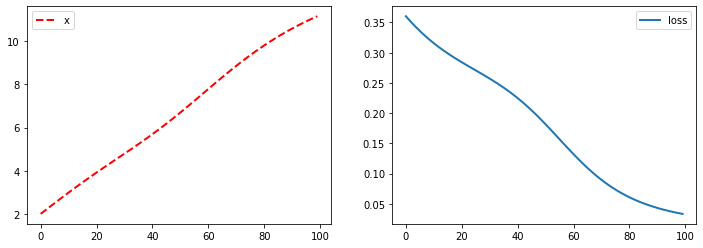

In [82]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(trace.x, 'r--', linewidth=2)
plt.legend(['x', 'B'])
plt.subplot(1,2,2)
plt.plot(trace.loss, linewidth=2)
plt.legend(['loss'])

clearly too low B doesn't work, what if we increase to improve precision?

In [85]:
x = torch.tensor(2.0, requires_grad=True)
model = CLNModel(B=100.0)

print('x before', x, '\nloss before', 1-model(x))
trace = train(x, model)
print('\nx after', x, '\nloss after', 1-model(x))

100%|██████████| 100/100 [00:00<00:00, 1059.74it/s]

x before tensor(2., requires_grad=True) 
loss before tensor(1., grad_fn=<RsubBackward1>)

x after tensor(2., requires_grad=True) 
loss after tensor(1., grad_fn=<RsubBackward1>)


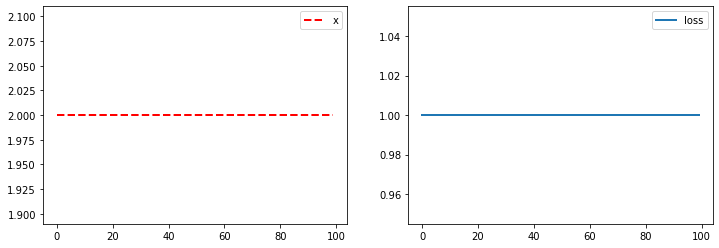

In [86]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(trace.x, 'r--', linewidth=2)
plt.legend(['x', 'B'])
plt.subplot(1,2,2)
plt.plot(trace.loss, linewidth=2)
plt.legend(['loss'])

In [87]:
# the gradient is nearly 0!
x.grad

tensor(-1.9287e-20)

### Training with learnable B params
Use gradients to pick B

100%|██████████| 100/100 [00:00<00:00, 1037.12it/s]

x before tensor(2., requires_grad=True)
x after tensor(3.4892, requires_grad=True)


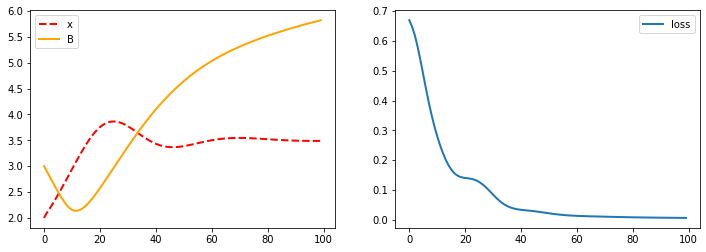

In [96]:
def train(x, model):
    opt = torch.optim.Adam(params=[x] + list(model.parameters()), lr=0.1)
    
    x_trace = []
    loss_trace = []
    B_trace = []
    for i in trange(100):
        opt.zero_grad()
        
        cln_out = model(x)
        loss = 1 - cln_out
        
        loss_trace.append(loss.item())
        x_trace.append(x.item())
        B_trace.append(model.B.item())

        loss.backward()
        opt.step()
        
        model.B.data.clamp_(min=0.5) # Make sure to clamp B!
        
    return pd.DataFrame({'loss':loss_trace, 'x':x_trace, 'B': B_trace})

x = torch.tensor(2.0, requires_grad=True)

model = CLNModel(B=torch.nn.Parameter(torch.tensor(3.0))) # set B to parameter

print('x before', x)
trace = train(x, model)
print('x after', x)



plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(trace.x, 'r--',linewidth=2)
plt.plot(trace.B, 'orange',linewidth=2)
plt.legend(['x', 'B'])
plt.subplot(1,2,2)
plt.plot(trace.loss, linewidth=2)
plt.legend(['loss'])